# Fundamentals of Machine Learning - Exercise 6

Johannes Kammerer, Zhao Sun, Tong Yu

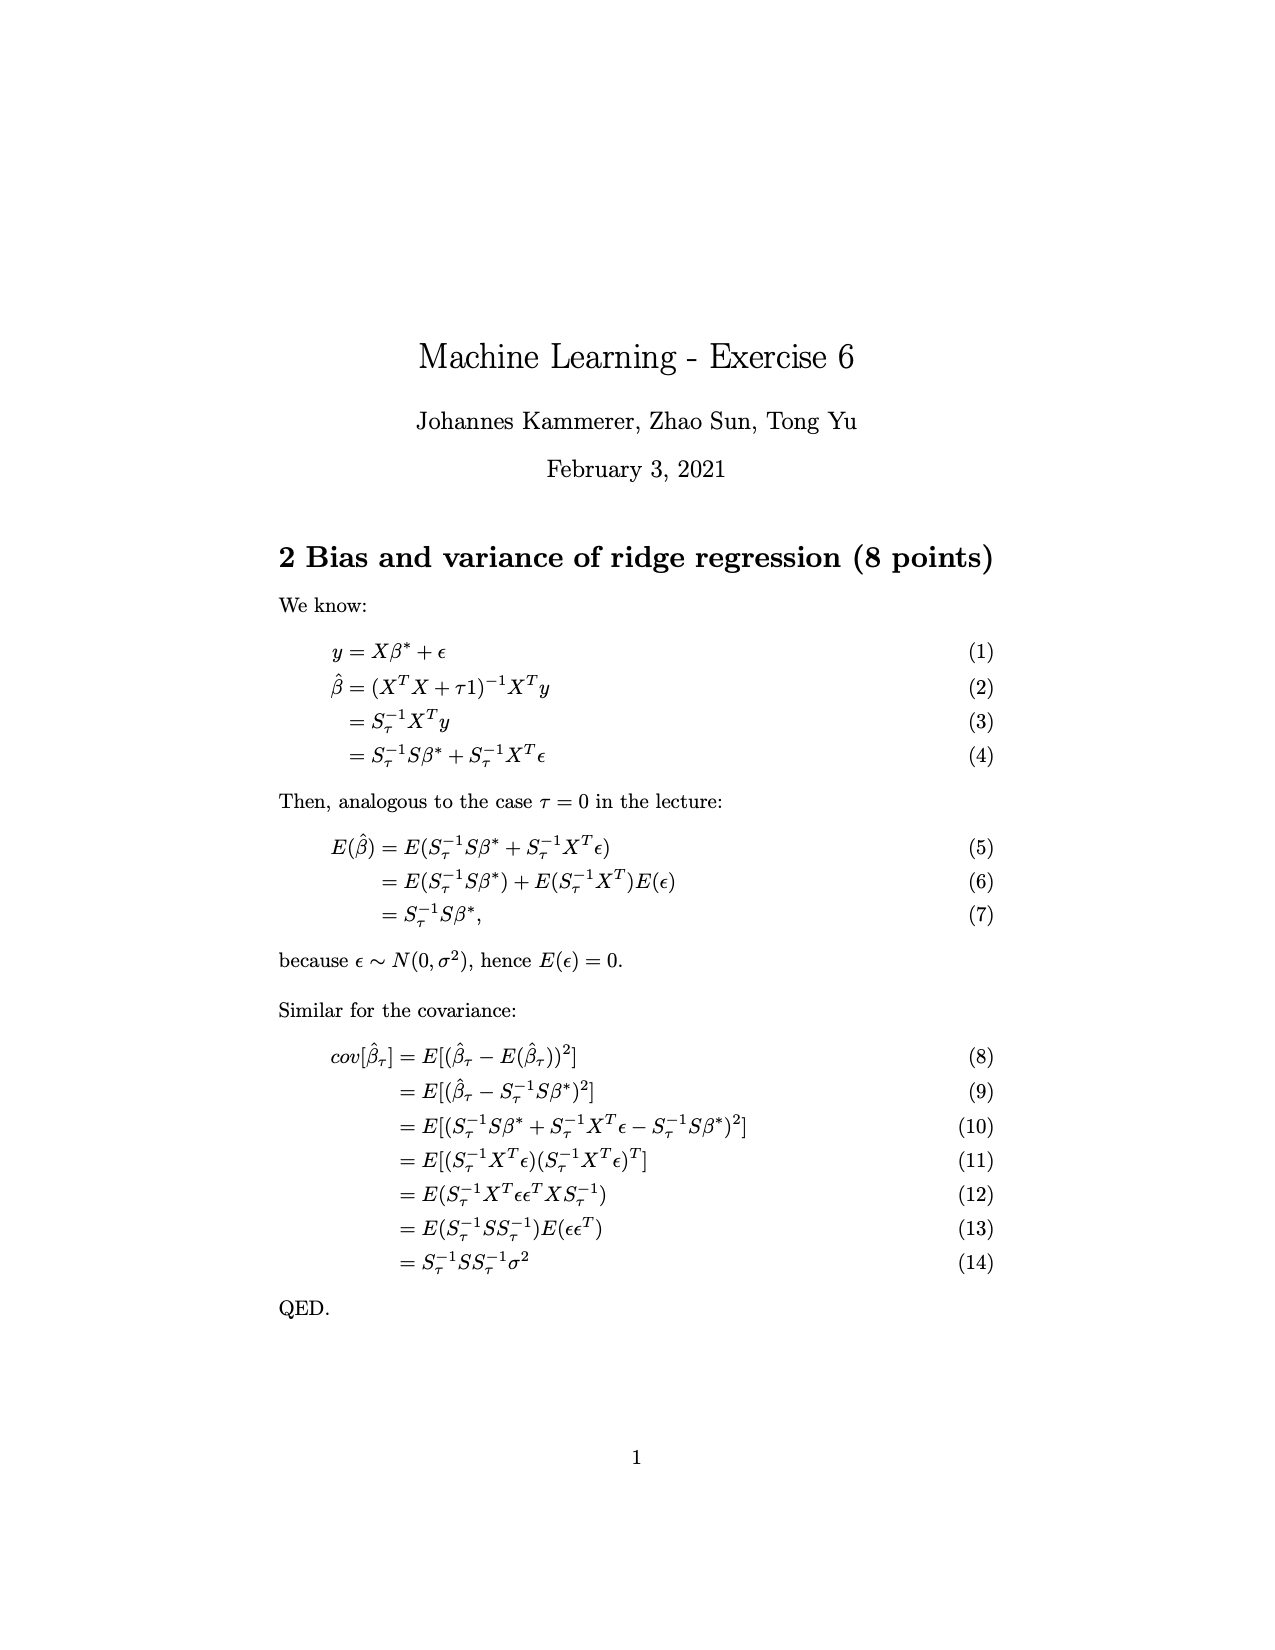

In [5]:
import os
os.chdir('/Users/jocelyn')
from IPython.display import Image
display(Image("6.2 Bias and Variance Proof_JK.png", width=700, height=700))

## 3 Denoising of a CT image (11 points)

In [7]:
# import
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, diags, vstack, hstack
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.linalg import lstsq
import sklearn
from sklearn.datasets import load_digits
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# construct matrix
def construct_X(M, alphas, Np = None, tau = 0, no_angles = None):
    '''
    Constructs sparse matrix X
    M: object dimension D=MxM
    alphas: list of angles
    Np: # sensor pixels
    '''    
    if Np == None:
        Np = (np.ceil(np.sqrt(2)*M)//2 * 2 + 1).astype(int) # rounds up to next odd integer
    #assert Np-1 >= np.sqrt(2)*(M-1) # for projection
    D = M**2
    N = len(alphas)*Np
    weights = []
    i_indices = []
    j_indices = []
    for io in range(len(alphas)):
        a = np.deg2rad(alphas[io])
        jb, ja = np.mgrid[0:M, 0:M]
        ja = ja.flatten()
        jb = jb.flatten()
        a0, b0 = -(M-1)/2, -(M-1)/2
        C0 = a0 + ja
        C1 = b0 + jb
        C = np.column_stack((C0, C1)).T
        n = np.column_stack((np.cos(a), -np.sin(a)))
        s0 = (Np-1)/2
        p = n@C + s0
        plow = np.floor(p)
        phigh = plow + 1
        Xlow = phigh-p
        Xhigh = p-plow
        weights = np.concatenate((weights, Xlow, Xhigh), axis=None)
        i_indices = np.concatenate((i_indices, plow + Np*io, phigh + Np*io), axis=None)
        j_indices = np.concatenate((j_indices, np.arange(D), np.arange(D)), axis=None)
     
    X = coo_matrix((weights, (i_indices, j_indices)), shape = (N, D), dtype = np.float32)
    if tau > 0:  
        diagonals = np.repeat(np.sqrt(tau), repeats = D)
        diagT = diags(diagonals)
        X = vstack([X, diagT])
    #print(X.shape)
    return X

In [5]:
X = construct_X(M = 10, alphas = [-33, 1, 42], tau = 1)
Xar = X.toarray()

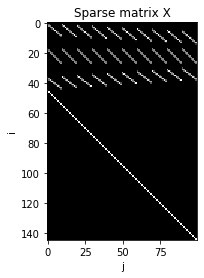

In [6]:
plt.imshow(Xar, cmap="gray")
plt.title('Sparse matrix X')
plt.xlabel('j')
plt.ylabel('i')
plt.show()

### Solution with Ridge Regression

In [7]:
# global variables
No = 179
Np = 275
M = 195
D = M**2

In [8]:
def reconstruct(taus, no_angles = 64, tol = 1e-03):
    # initialize
    sol = []
    
    # load data
    alphas_195 = np.load('hs_tomography/alphas_195.npy')
    y_195 = np.load('hs_tomography/y_195.npy')

    for tau in taus:
        # construct sparse matrix in COO and CSC format
        COO_195 = construct_X(M = 195, alphas = alphas_195, Np = 275, tau=tau)
        CSC_195 = COO_195.tocsc()

        # select no_angles projection angles
        pos = np.arange(No*Np).reshape((No,Np))
        ios = np.sort(np.random.choice(No, no_angles, replace = False))
        pos = pos[ios,:].flatten()
        y = y_195[pos]
        Xpos = np.concatenate((pos, np.arange(-D, 0))) if tau > 0 else pos
        CSC = CSC_195[Xpos,:]

        # extend y with D zeros
        if tau > 0:
            y_ext = np.zeros(CSC.shape[1])
            y = np.concatenate((y, y_ext))

        # solve sparse linear equation
        b = lsqr(CSC, y, atol=tol, btol=tol)[0]
        sol.append(b)
        
    return sol

In [9]:
tauvalues = [0, 1, 10, 100, 1e3, 1e4]
sol = reconstruct(taus = tauvalues, tol = 1e-05)

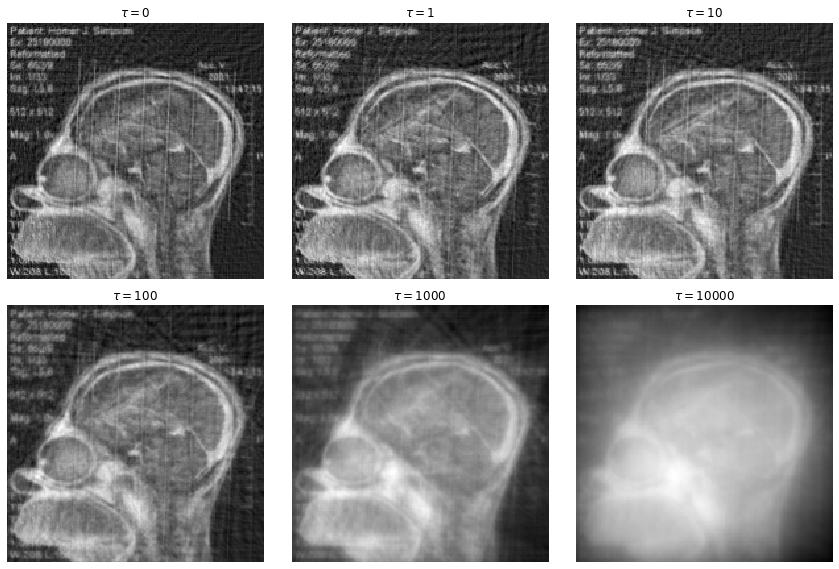

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)
for i in range(6):
    axes[i//3,i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//3,i%3].set_axis_off()
    axes[i//3,i%3].set_title(r'$\tau=%i$' %tauvalues[i])
plt.show()

<span style="font-weight: bold"><ins>Comparison: </ins> \
    We observe that for a small $\tau$ the sharpness increases because the Ridge regression descreases the noise (variance) of the solution. However, it introduces a bias in the result which can be seen in the increased brightness of the skull for large values of $\tau$. At about $\tau=1$, the bullet can be resolved best and hast the highest sharpness.</span>

### Solution with Gaussian filtering

In [11]:
filters = [0,1,2,3,5,7]
sol = []
for f in filters:
    tomo = reconstruct(taus = [0], tol = 1e-05)[0]
    sol_f = gaussian_filter(tomo, sigma=f)
    sol.append(sol_f)

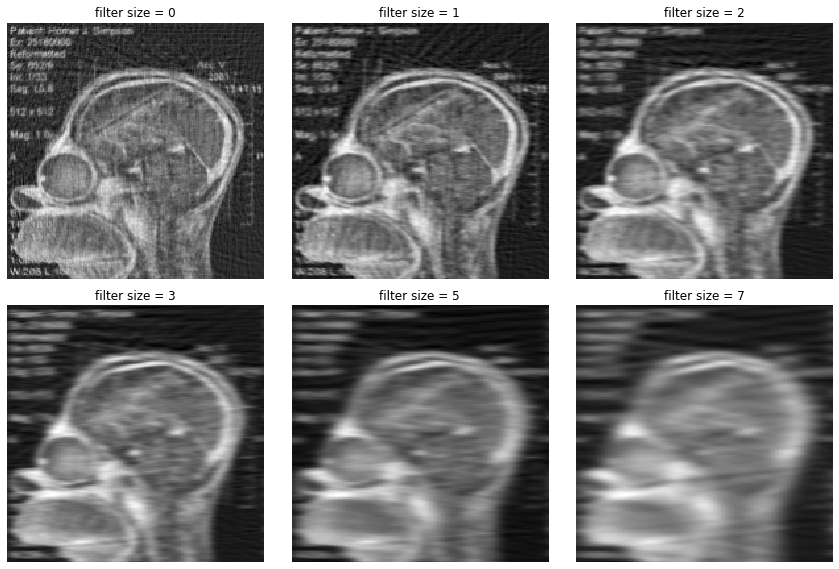

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)
for i in range(6):
    axes[i//3,i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//3,i%3].set_axis_off()
    axes[i//3,i%3].set_title('filter size = %i' %filters[i])
plt.show()

<span style="font-weight: bold"><ins>Observation: </ins>\
In the method 'gaussian filtering', each pixel is replaced by the weighted average of its neighboring pixels. The parameter $\sigma$ determines the size of the neighborhood. We observe that for $\sigma=1$, the image already becomes more blurry, but some variance has been reduced and the bullet can be resolved. For the larger $\sigma$ values, the image is more and more blurred. \
<ins>Comparison: </ins> \
In this case, the Ridge regression is superior to the gaussian filtering, because the variance seems to happen on small scales and the filtering averages over too large an area which leads to the blurred appearance. We would therefore choose the Ridge regression. \
<ins>Addition: </ins> \
We estimate the values of the parameter $\sigma$ is too large for the variance in this image. Therefore we test smaller values, too (see below). Here we find that, e.g., $\sigma=0.1$ effectively reduces the noise and increases the sharpness of the image. The bullet can be resolved properly here.</span>

In [13]:
filters = [0,0.1,0.5]
sol = []
for f in filters:
    tomo = reconstruct(taus = [0], tol = 1e-05)[0]
    sol_f = gaussian_filter(tomo, sigma=f)
    sol.append(sol_f)

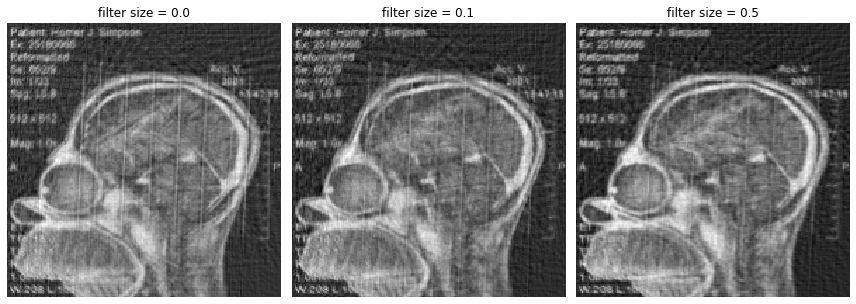

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12,8), tight_layout=True)
for i in range(3):
    axes[i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i%3].set_axis_off()
    axes[i%3].set_title('filter size = %.1f' %filters[i])
plt.show()

## Automatic feature selection for regression
### 4.1 Implement Orthogonal Matching Pursuit (5 points)

In [8]:
# orthogonal matching pursuit
def omp_regression(X, y, T):
    '''
    selects relevant features
    input: X(N,D), y(N), T
    '''
    # initialize
    N, D = X.shape
    A = []
    B = list(np.arange(D))
    r = y
    js = []
    beta = np.zeros((D,T))
    # iteration
    for t in range(T):
        # step 1: find most relevant inactive column
        cor = 0
        jrel = None
        for j in B:
            newcor = np.linalg.norm(X[:,j]*r)
            if newcor > cor:
                jrel = j
                cor = newcor
        js.append(jrel)
        # step 2: move j to active set
        B.remove(jrel)
        A.append(jrel)
        # step 3: update active matrix
        Xact = X[:,A]
        # step 4: solve LS problem
        b = lstsq(Xact, y)[0]
        # step 5: update residual
        r = y - np.dot(Xact, b)
        # step 6: append beta to solution vector
        beta[js,t] = b
    return beta

### 4.2 Classication with sparse LDA (8 points)

In [9]:
# initalize
# #training instances = 179
# #features = 64
digits = load_digits()
pos1 = list(np.where(digits['target'] == 1)[0][:179]) #182->179 balanced
pos7 = list(np.where(digits['target'] == 7)[0])
pos = np.sort(pos1+pos7)
X = digits['data'][pos]
labels = digits['target'][pos]
y = 1*(labels==1)-1*(labels==7)
assert sum(y)==0 # check: balanced data set

In [10]:
T = 50
sol = omp_regression(X, y, T)
betaT = sol[:,-1] # last column with T non-negative elements
error = [np.linalg.norm(np.dot(X, sol[:,t])-y) for t in range(T)] # sum of squared errors
#error = [sum(np.abs(np.dot(X, sol[:,t])-y)) for t in range(T)] # linear errors

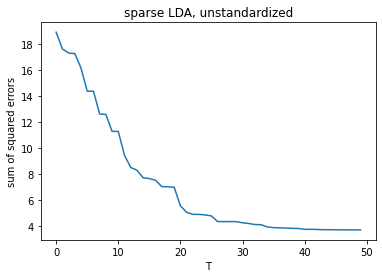

In [11]:
t = np.arange(T)
plt.plot(t,error)
plt.xlabel('T')
plt.ylabel('sum of squared errors')
plt.title('sparse LDA, unstandardized')
plt.show()

In [12]:
# standardize
Xst = X - X.mean(axis=0) #col-wise

In [13]:
T = 50
solst = omp_regression(Xst, y, T)
betaTst = solst[:,-1] # last column with T non-negative elements
errorst = [np.linalg.norm(np.dot(Xst, solst[:,t])-y) for t in range(T)] # sum of squared errors
#error = [sum(np.abs(np.dot(X, sol[:,t])-y)) for t in range(T)] # linear errors

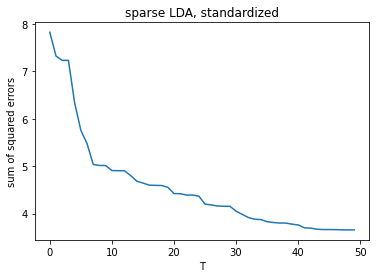

In [14]:
t = np.arange(T)
plt.plot(t,errorst)
plt.xlabel('T')
plt.ylabel('sum of squared errors')
plt.title('sparse LDA, standardized')
plt.show()

<span style="font-weight: bold"><ins>T value: </ins>\
The error rate decreases with increasing T because with more features the accuracy of the prediction improves. At $T=30$, the error rate has significantly decreased. \
<ins>Standardization: </ins> \
In the second plot, we standardized the values of both the training and test instances. We still see a similar shape of the error rate curve. The is some difference in the absolute error values, but the form of the figures are similar. Therefore, we will use the unstandardized values in the following. We also tested the linear sum of errors which showed qualitatively similar results.

<span style="font-weight: bold"><ins>Sequence of the feature selection: </ins>\
The following two plots show the sequence in which the features are selected (for the standardized and not standardized data sets). Pixels with white color represent features that vote for class one and black features vote for class 7. The closer a color is to gray, the smaller its influence. In the beginning, features in the middle are selected. In the standardized case, we see two circles (second row) where pixels are relevant. Apart from that and unexpectedly, the black and white pixels do not show any pattern that can be recognized. There are no clear "regions" with only black or white values. No pattern emerges that could be verbally described as the characteristics of a "typical 1" or "typical 7". \
<ins>Comparison to hand-crafted feature selection: </ins> \
In excercise two, our two features were (1) the middle pixels of the two top rows and (2) the middle of the three bottom rows. In the OMP, it is rather the middle of the first row and of the bottom row.

Sequence of feature selection (unstandardized)


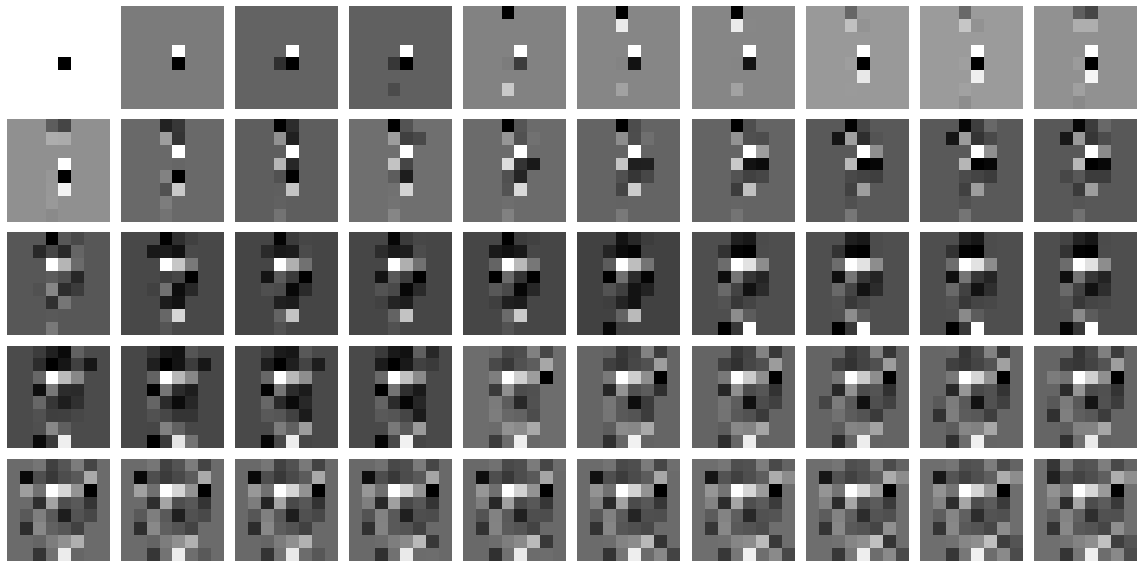

In [125]:
print('Sequence of feature selection (unstandardized)')
fig, axes = plt.subplots(5, 10, figsize=(16, 8), tight_layout=True)
for t in range(T):
    img = sol[:,t]
    axes[t//10,t%10].imshow(img.reshape((8,8)), cmap="gray", vmin=np.min(img), vmax=np.max(img))
    axes[t//10,t%10].set_axis_off()
plt.show()

Sequence of feature selection (standardized)


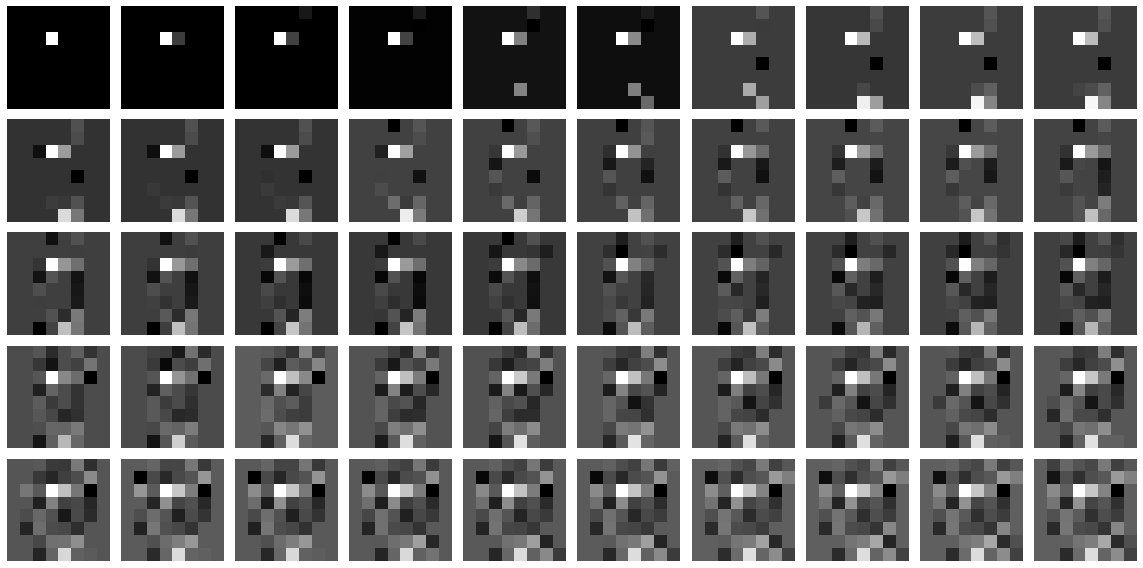

In [126]:
print('Sequence of feature selection (standardized)')
fig, axes = plt.subplots(5, 10, figsize=(16, 8), tight_layout=True)
for t in range(T):
    img = solst[:,t]
    axes[t//10,t%10].imshow(img.reshape((8,8)), cmap="gray", vmin=np.min(img), vmax=np.max(img))
    axes[t//10,t%10].set_axis_off()
    #axes[i//5,i%5].set_title(r'$\tau=%i$' %tauvalues[i])
plt.show()

### 4.3 One-against-the-rest classication (8 points)

In [147]:
digits = load_digits()

def sparseLDA(k, T=30):
    # create training set
    posk = list(np.where(digits['target'] == k)[0])
    Nk = len(posk)
    notk = list(np.where(digits['target'] != k)[0])
    posnotk = list(np.random.choice(notk, Nk, replace = False))
    pos = np.sort(posk+posnotk)
    X = digits['data'][pos]
    labels = digits['target'][pos]
    y = 1*(labels==k)-1*(labels!=k)
    assert sum(y)==0 # check: balanced data set
    
    # OMP regression
    sol = omp_regression(X, y, T)
    betaT = sol[:,-1] # last column with T non-negative elements
    return betaT
    
b = [sparseLDA(k) for k in range(10)]

In [148]:
def testC(inst):
    resp = [np.dot(inst.T, b[k]) for k in range(10)]
    if np.max(resp) > 0:
        label = np.argmax(resp)
    else:
        label = 10
        unknowns.append(inst)
    return label

In [149]:
unknowns = []
def confMatrix():
    conf = np.zeros((10,11))
    for k in range(10):
        pred = [testC(inst) for inst in digits['data'][digits['target'] == k]]
        conf[k,:] = np.bincount(pred, minlength=11)/len(pred)*100
    display(
        pd.DataFrame(data = conf, index =range(10), columns =range(11))
        .rename_axis('Actual/Predicted', axis = 'columns')
    )

In [150]:
print('Confusion Matrix (10=unknown):')
confMatrix()

Confusion Matrix (10=unknown):


Actual/Predicted     0     1     2     3     4     5     6     7     8     9  \
0                98.31  0.00  0.00  0.00  0.56  1.12  0.00  0.00  0.00  0.00   
1                 0.00 92.31  0.00  1.65  0.55  0.55  1.10  0.00  0.00  3.85   
2                 0.00  2.26 94.92  2.26  0.00  0.00  0.00  0.00  0.56  0.00   
3                 0.00  0.55  0.55 93.44  0.00  1.09  0.00  0.55  2.19  1.09   
4                 0.00  1.10  0.00  0.00 92.82  0.00  1.10  1.66  2.76  0.55   
5                 0.55  1.10  0.00  0.00  0.00 96.15  0.00  0.00  0.00  2.20   
6                 0.00  1.10  0.00  0.00  0.00  0.55 97.79  0.00  0.55  0.00   
7                 0.00  0.00  0.00  1.12  0.00  1.12  0.00 93.30  2.23  1.68   
8                 0.00  4.02  0.00  1.15  0.00  1.72  0.57  0.57 82.18  5.17   
9                 0.00  0.56  0.00  1.67  0.00  0.00  0.00  2.22  3.89 91.67   

Actual/Predicted   10  
0                0.00  
1                0.00  
2                0.00  
3                0.55  
4                0.00  
5                0.00  
6                0.00  
7                0.56  
8                4.60  
9                0.00

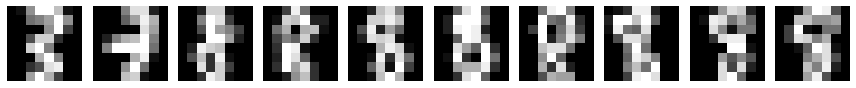

In [152]:
fig, axes = plt.subplots(1, len(unknowns), figsize=(12, 6), tight_layout=True)
for i in range(len(unknowns)):
    img = unknowns[i]
    axes[i].imshow(img.reshape((8,8)), cmap="gray", vmin=np.min(img), vmax=np.max(img))
    axes[i].set_axis_off()
    #axes[i//5,i%5].set_title(r'$\tau=%i$' %tauvalues[i])
plt.show()

<span style="font-weight: bold"><ins>Class 'unknown': </ins>\
It is useful to introduce the class 'unknown' to understand which patterns typically have difficulties and coincide with none of the classifier labels. Those ones have a negative response for each class. In the visualization, we see that those are ones the are often numbers with circles, e.g. 8 or 9. 